
Decoding with ANOVA + SVM: face vs house in the Haxby dataset
===============================================================

This example does a simple but efficient decoding on the Haxby dataset:
using a feature selection, followed by an SVM.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

Retrieve the files of the Haxby dataset
----------------------------------------



In [2]:
from nilearn import datasets

# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

Mask nifti image (3D) is located at: /Users/Ralf/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/Ralf/nilearn_data/haxby2001/subj2/bold.nii.gz


Load the behavioral data
-------------------------



In [3]:
import pandas as pd

# Load target information as string and give a numerical identifier to each
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']

# Restrict the analysis to faces and places
condition_mask = behavioral['labels'].isin(['face', 'house'])
conditions = conditions[condition_mask]

# Confirm that we now have 2 conditions
print(conditions.unique())

# Record these as an array of sessions, with fields
# for condition (face or house) and run
session = behavioral[condition_mask].to_records(index=False)
print(session.dtype.names)

['face' 'house']
('labels', 'chunks')


Prepare the fMRI data: smooth and apply the mask
-------------------------------------------------



In [4]:
from nilearn.input_data import NiftiMasker

mask_filename = haxby_dataset.mask

# For decoding, standardizing is often very important
# note that we are also smoothing the data
masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4,
                     standardize=True, memory="nilearn_cache", memory_level=1)
func_filename = haxby_dataset.func[0]
X = masker.fit_transform(func_filename)
# Apply our condition_mask
X = X[condition_mask]

Build the decoder
------------------
Define the prediction function to be used.
Here we use a Support Vector Classification, with a linear kernel



In [5]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. When doing full-brain analysis, it is better to use
# SelectPercentile, keeping 5% of voxels
# (because it is independent of the resolution of the data).
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=5)

# We have our classifier (SVC), our feature selection (SelectPercentile),and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

Fit the decoder and predict
----------------------------



In [6]:
anova_svc.fit(X, conditions)
y_pred = anova_svc.predict(X)

Obtain prediction scores via cross validation
-----------------------------------------------



In [7]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneGroupOut cross-validation on the session group
# which corresponds to a leave-one-session-out
cv = LeaveOneGroupOut()

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = cross_val_score(anova_svc, X, conditions, cv=cv, groups=session)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / len(conditions.unique())))
# Classification accuracy:  0.70370 / Chance level: 0.5000

Classification accuracy: 0.7037 / Chance level: 0.500000


Visualize the results
----------------------
Look at the SVC's discriminating weights



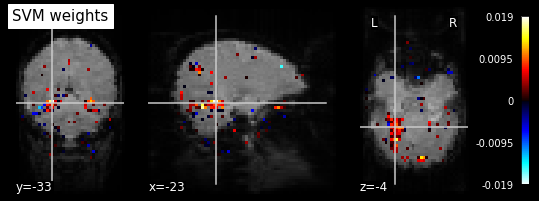

In [8]:
coef = svc.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse masking
weight_img = masker.inverse_transform(coef)


# Use the mean image as a background to avoid relying on anatomical data
from nilearn import image
mean_img = image.mean_img(func_filename)

# Create the figure
from nilearn.plotting import plot_stat_map, show
plot_stat_map(weight_img, mean_img, title='SVM weights')

# Saving the results as a Nifti file may also be important
weight_img.to_filename('haxby_face_vs_house.nii')


show()

***Exercise:***

What do you see? 